In [1]:
import qiskit
from qiskit.quantum_info import state_fidelity
import numpy as np
from scipy.sparse import linalg as LA
import qib
import matplotlib.pyplot as plt
import rqcopt as oc
import scipy
import scipy.sparse as sp
from qiskit.circuit.library import CXGate, CYGate, CZGate
from qiskit import Aer, execute, transpile
from qiskit.providers.aer.noise import NoiseModel, errors
from qiskit.converters import circuit_to_dag

import sys
sys.path.append("../../src/qetu")
from qetu import qetu_rqc_oneLayer


X = np.array([[ 0.,  1.], [ 1.,  0.]])
Y = np.array([[ 0., -1j], [ 1j,  0.]])
Z = np.array([[ 1.,  0.], [ 0., -1.]])
I = np.identity(2)


def construct_heisenberg_local_term(J, h, ndims=1):
    return (  J[0]*np.kron(X, X)
            + J[1]*np.kron(Y, Y)
            + J[2]*np.kron(Z, Z)
            + h[0]*(0.5/ndims)*(np.kron(X, I) + np.kron(I, X))
            + h[1]*(0.5/ndims)*(np.kron(Y, I) + np.kron(I, Y))
            + h[2]*(0.5/ndims)*(np.kron(Z, I) + np.kron(I, Z)))

/tmp/ipykernel_10201/1964218335.py:12: DeprecationWarning: Importing from 'qiskit.providers.aer' is deprecated. Import from 'qiskit_aer' instead, which should work identically.
  from qiskit.providers.aer.noise import NoiseModel, errors


In [115]:
def uncompr_trotterized_time_evolution(qc, hlocs, t, gate_b, gate_a, lamb=None):
    # permutations specifying gate layout
    perms1 = [i for i in range(L)]
    perms2 = [i for i in range(1, L)]+[0]
    perm_set = [perms1, perms2]
    perms = perm_set
    
    K_layer_b = [None for _ in range(L)]
    for j in range(len(perms[0])//2):
        K_layer_b[perms[0][2*j]] = gate_b
        K_layer_b[perms[0][2*j+1]] = None
    K_layer_a = [None for _ in range(L)]
    for j in range(len(perms[0])//2):
        K_layer_a[perms[0][2*j]] = gate_a
        K_layer_a[perms[0][2*j+1]] = None
        
    K_b = [K_layer_b, None]
    K_a = [None, K_layer_a]
    
    Vlists = [[scipy.linalg.expm(-1j*t*hloc) for i in range(len(perm_set))] for hloc in hlocs]
    Vlists_gates = [[] for _ in hlocs]
    for i, Vlist in enumerate(Vlists):
        for V in Vlist:
            qc2 = qiskit.QuantumCircuit(2)
            qc2.unitary(V, [0, 1], label='str')
            Vlists_gates[i].append(qc2)


    for layer in range(len(perms)):
        if K_b[layer] is not None:
            qc.x(L)
            for j in range(L):
                if K_b[layer][j] is not None:
                    qc.append(K_b[layer][j](), [L, L-1-j])
            qc.x(L)

            
        for Vlist_gates in Vlists_gates:
            qc_gate = Vlist_gates[layer]
            
            for j in range(len(perms[layer])//2):
                    qc.append(qc_gate.to_gate(), [L-(perms[layer][2*j]+1), 
                                                    L-(perms[layer][2*j+1]+1)])

        if K_a[layer] is not None:
            qc.x(L)
            for j in range(L):
                if K_a[layer][j] is not None:
                    qc.append(K_a[layer][j](), [L, L-1-j])
            qc.x(L)


def uncompr_controlled_trotter(c1, c2, L, J, h=(0,0,0), dagger=False, nsteps=1):
    if c1/(2*nsteps) > 0.25:
        nsteps = int(np.ceil(c1/(2 * 0.25
                                )))
        print("nsteps set to: ", nsteps)
        print("dt set to: ",  c1/(2*nsteps))
    dt = c1/(2*nsteps)
    t = c1/2
    
    hloc1 = construct_heisenberg_local_term((J[0], 0, 0), h)
    hloc2 = construct_heisenberg_local_term((0, J[1], 0), h)
    hloc3 = construct_heisenberg_local_term((0, 0, J[2]), h)
    qc_cU_ins = qiskit.QuantumCircuit(L+1)

    if dagger:
        qc_cU_ins.x(L)

    hs = ((hloc1, ), (hloc2, ), (hloc3, ))
    cgates = ((CZGate, None), (None, CZGate), (CYGate, CYGate), (CZGate, None), (None, CZGate))
    indices = [0, 1, 2, 1, 0]
    coeffs  = [.5, .5, 1, .5, .5]

    for n in range(nsteps):
        layer = 0
        for index, coef in zip(indices, coeffs):
            uncompr_trotterized_time_evolution(qc_cU_ins, hs[index], dt * coef, cgates[layer][0], cgates[layer][1])
            layer += 1

    qc_cU_ins.cp(-c2, L,  0)
    qc_cU_ins.x(0)
    qc_cU_ins.cp(-c2, L, 0)
    qc_cU_ins.x(0)

    if dagger:
        qc_cU_ins.x(L)

    return qc_cU_ins

In [108]:

def run_qetu(c1, c2, mu=0.9, d=8, M=1, return_circ=False, qc_init=None, full_measure=False,
            return_one_layer=False, a_assess=None, reverse=False):

    qc_cU = uncompr_controlled_trotter(c1, c2, L, J,  dagger=False)
    qc_cU_dag = uncompr_controlled_trotter(c1, c2, L, J,  dagger=True)
    qc_cfUs = [qc_cU, qc_cU_dag]
    
    ket_0 = np.array([1,0])
    
    # QETU Circuit:
    c, phis_max_iter, = (0.95, 10)
    qc_qetu, _ = qetu_rqc_oneLayer(L, 0, 0, 1, mu, d=d, c2=0,
                                    qc_cU_custom=(qc_cfUs[0], qc_cfUs[1]), a_assess=a_assess, reverse=reverse)
                                    
    qcs_qetu = []
    for m in range(M):
        qcs_qetu.append(qc_qetu)

    if return_one_layer:
        return qc_qetu

    if return_circ:
        mid_cbits = len(qcs_qetu)
        qc = qiskit.QuantumCircuit(L+1, (L+1 if full_measure else 1) + mid_cbits)
        if qc_init is not None:
            qc.append(qc_init.to_gate(), [i for i in range(L)])
        
        for j, qc_qetu in enumerate(qcs_qetu):
            qc.append(qc_qetu.to_gate(), [i for i in range(L+1)])
            qc.measure(L, j)
        return qc, mid_cbits
    else:
        backend = Aer.get_backend("statevector_simulator")
        qc_RQC = qiskit.QuantumCircuit(L+1)
        #qc_RQC.initialize(np.kron(ket_0, state))
        if qc_init is not None:
            qc_RQC.append(qc_init.to_gate(), [i for i in range(L)])
        
        for qc_qetu in qcs_qetu:
            qc_RQC.append(qc_qetu.to_gate(), [i for i in range(L+1)])
            bR = execute(transpile(qc_RQC), backend).result().get_statevector().data
            aR = sp.kron(np.array([[1,0],[0,0]]), sp.eye(2**L)) @ bR
            print("Success Prob: ", np.linalg.norm(aR)**2)
            aR = aR / np.linalg.norm(aR)
            qc_RQC.reset([i for i in range(L+1)])
            qc_RQC.initialize(aR)
        toPlot = [state_fidelity(aR[:2**L], eigenvectors_sort[:, i]) for i in range(6)]
        print("AQC+F: ", toPlot[0])
    
        qc = qiskit.QuantumCircuit(L+1, 1)
        if qc_init is not None:
            qc.append(qc_init.to_gate(), [i for i in range(L)])
        for j, qc_qetu in enumerate(qcs_qetu):
            qc.append(qc_qetu.to_gate(), [i for i in range(L+1)])
            qc.measure(L, j)
        
        noise_model = NoiseModel()
        dag = circuit_to_dag(transpile(qc, basis_gates=noise_model.basis_gates+['unitary', 'initialize', 'cx']))
        count_ops = dag.count_ops()
        return np.array([toPlot[i] for i in range(6)]), {"count_ops": count_ops["unitary"]+count_ops["cx"]}

In [109]:
"""
    Adiabatic Evolution Implementation.
"""


def trotter(tau, L, J, h, lamb):
    assert lamb <= 1 and lamb >= 0
    qc = qiskit.QuantumCircuit(L)
    
    # permutations specifying gate layout
    perms1 = [i for i in range(L)]
    perms2 = [i for i in range(1, L)]+[0]
    perm_set = [perms1, perms2]
    perms = perm_set

    #method_start = oc.SplittingMethod.suzuki(len(perms), 1)
    indices = [0, 1, 0, 1, 0]
    coeffs = [.25, .5, .5, .5, .25]
    hloc = construct_heisenberg_local_term(J, h, 1)

    # unitaries used as starting point for optimization
    Vlist_start = []
    perms = []
    
    for i, c in zip(indices, coeffs):
        Vlist_start.append(
            scipy.linalg.expm(-1j*c*tau*hloc *\
                (lamb if i in [1, 3] else 1))
        )
        perms.append(perm_set[i])
    Vlist_gates = []
    for V in Vlist_start:
        qc2 = qiskit.QuantumCircuit(2)
        qc2.unitary(V, [0, 1], label='str')
        Vlist_gates.append(qc2)
    
    for layer, qc_gate in enumerate(Vlist_gates):     
        for j in range(len(perms[layer])//2):
            qc.append(qc_gate.to_gate(), [L-(perms[layer][2*j]+1), 
                                          L-(perms[layer][2*j+1]+1)])
    
    return qc


def run_adiabatic(T, S, return_state=False, return_final_qc=False):
    tau = 1/S
    t_s = np.linspace(0, T, S*T)
    sch = lambda t, T: np.sin(np.pi*t/(2*T))**2

    final_qc = None
    qc = qiskit.QuantumCircuit(L)
    for s in range(S*T):
        qc.append(trotter(tau, L, J, h, sch(t_s[s], T)).to_gate(),
                  [i for i in range(L)])
        if s==S*T-1:
            print(sch(t_s[s], T))
            final_qc = trotter(tau, L, J, h, sch(t_s[s], T))
    
    backend = Aer.get_backend("statevector_simulator")
    qc_ = qiskit.QuantumCircuit(L)
    qc_.initialize(state)
    qc_.append(qc.to_gate(), [i for i in range(L)])
    final = execute(transpile(qc_), backend).result().get_statevector().data
    toPlot = [state_fidelity(final, eigenvectors_sort[:, i]) for i in range(10)]

    print("Fidelity: ", np.array([toPlot[i] for i in range(10)]))

    if return_final_qc:
        return qc, final_qc
    
    if return_state:
        return qc
    else:
        noise_model = NoiseModel()
        dag = circuit_to_dag(transpile(qc_, basis_gates=noise_model.basis_gates+['unitary', 'initialize', 'cx']))
        count_ops = dag.count_ops()
        
        return [state_fidelity(final, eigenvectors_sort[:, i]) for i in range(10)], {"gates": count_ops['unitary']}, final


In [110]:
cxs = {}
fids = {}
cxs_A = {}
fids_A = {}

In [130]:
J = (1, 1, 1)
h = (0, 0, 0)
Ts = {8: range(2, 10, 2), 12: range(2, 25, 4), 14: range(1, 8, 1), 16: range(1, 8, 1), 18: range(1, 8, 1), 20: range(1, 8, 1)}
Ts_A = {8: range(4, 15, 2), 12: range(4, 30, 4), 14: range(3, 12, 1), 16: range(3, 12, 1), 18: range(3, 12, 1), 20: range(3, 12, 1)}


for L in [14]:
    cxs[L] = []
    fids[L] = []
    cxs_A[L] = []
    fids_A[L] = []
    
    latt_i = qib.lattice.IntegerLattice((2,), pbc=True)
    field_i = qib.field.Field(qib.field.ParticleType.QUBIT, latt_i)
    h_i = qib.HeisenbergHamiltonian(field_i, J, h).as_matrix()
    H_i = sp.csr_matrix((2**L, 2**L))
    # Expand
    for i in range(L//2):
        H_ii = sp.eye(1)
        for j in range(i):
            H_ii = sp.kron(H_ii, sp.eye(2**2), format='csr')
        H_ii = sp.kron(H_ii, h_i, format='csr')
        for j in range(i+1, L//2):
            H_ii = sp.kron(H_ii, sp.eye(2**2), format='csr')
        H_i = H_i + H_ii
    eigenvalues, eigenvectors = LA.eigsh(H_i, k=10)
    idx = eigenvalues.argsort()
    eigenvectors_sort = eigenvectors[:,idx]
    state = eigenvectors_sort[:, 0]
    
    # construct Hamiltonian
    latt = qib.lattice.IntegerLattice((L, ), pbc=True)
    field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
    hamil = qib.HeisenbergHamiltonian(field, J, h).as_matrix()
    eigenvalues, eigenvectors = LA.eigsh(hamil, k=10)
    idx = eigenvalues.argsort()
    eigenvalues_sort = eigenvalues[idx]
    eigenvectors_sort = eigenvectors[:,idx]
    ground_state = eigenvectors_sort[:, 0]
    print("GS ", eigenvalues_sort[0])
    print("FES ", eigenvalues_sort[4])

    spectrum_upper_bound = eigenvalues_sort[4]+2
    spectrum_lower_bound = eigenvalues_sort[0]-2
    max_spectrum_length = spectrum_upper_bound - spectrum_lower_bound
    c1 = (np.pi) / (max_spectrum_length)
    c2 = - c1 * spectrum_lower_bound
    print("t: ", c1/2)
    eigenvalues_tr = eigenvalues_sort * c1 + c2
    a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])
    print("a values ", a_values[0], ", ", a_values[4])

    for i, T in enumerate(list(Ts[L])):
        # Give qc.
        qc_A = run_adiabatic(T=T, S=4, return_state=True)
        qc_C = qiskit.QuantumCircuit(L)
        for q in range(L//2):
            qc_C.x(2*q)
            qc_C.h(2*q)
            qc_C.x(2*q+1)
            qc_C.cx(2*q, 2*q+1)
        qc_C.append(qc_A.to_gate(), [i for i in range(L)])
        fid, gates = run_qetu(c1, c2, mu=0.8, d=4, M=1, qc_init=qc_C, a_assess=2)
        cxs[L].append(gates['count_ops'])
        fids[L].append(fid[0])
        print('cxs ', gates['count_ops'])

    for i, T in enumerate(list(Ts_A[L])):
        qc_A, qc_Trotter = run_adiabatic(T=T, S=4, return_final_qc=True)
        qc_C = qiskit.QuantumCircuit(L)
        for q in range(L//2):
            qc_C.x(2*q)
            qc_C.h(2*q)
            qc_C.x(2*q+1)
            qc_C.cx(2*q, 2*q+1)
        qc_C.append(qc_A.to_gate(), [i for i in range(L)])
    
        backend = Aer.get_backend("statevector_simulator")
        bR = execute(transpile(qc_C), backend).result().get_statevector().data
        fid = state_fidelity(bR, eigenvectors_sort[:, 0])
        fids_A[L].append(fid)
        
        noise_model = NoiseModel()
        dag = circuit_to_dag(transpile(qc_C, basis_gates=noise_model.basis_gates+['unitary', 'initialize', 'cx']))
        count_ops = dag.count_ops()
        cx = count_ops['unitary']
        cxs_A[L].append(cx)
        print('cxs_A ', cx)


GS  -25.054198134188482
FES  -22.992250690760283
t:  0.25912404247216103
a values  0.8686883392689858 ,  0.49535903062131675
1.0
Fidelity:  [5.24866962e-01 7.58860148e-30 1.11887138e-31 3.15317791e-31
 3.84083434e-01 1.13554066e-28 9.52050190e-31 3.91102957e-31
 7.65754548e-32 6.67344270e-30]
nsteps set to:  2
dt set to:  0.12956202123608052
nsteps set to:  2
dt set to:  0.12956202123608052


/tmp/ipykernel_10201/142561009.py:63: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  final = execute(transpile(qc_), backend).result().get_statevector().data


Constructing QETU sequence


/tmp/ipykernel_10201/2888741326.py:41: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  bR = execute(transpile(qc_RQC), backend).result().get_statevector().data


Success Prob:  0.26411505406164804
AQC+F:  0.8319778470092463
cxs  603
1.0
Fidelity:  [7.33449968e-01 1.72442524e-29 7.95025533e-32 6.69270982e-31
 2.62026284e-01 9.11260217e-29 1.88221312e-30 2.61264622e-31
 1.95044924e-31 5.37289218e-30]
nsteps set to:  2
dt set to:  0.12956202123608052
nsteps set to:  2
dt set to:  0.12956202123608052
Constructing QETU sequence
Success Prob:  0.3192472884678439
AQC+F:  0.9619883349407645
cxs  743
1.0
Fidelity:  [8.25307237e-01 2.46855572e-29 5.10443971e-32 6.09326348e-31
 1.73087300e-01 4.21025956e-29 2.40820123e-30 8.85024995e-31
 2.55396848e-31 4.96838728e-30]
nsteps set to:  2
dt set to:  0.12956202123608052
nsteps set to:  2
dt set to:  0.12956202123608052
Constructing QETU sequence
Success Prob:  0.35340336174750525
AQC+F:  0.9778502627606088
cxs  883
1.0
Fidelity:  [8.81920968e-01 1.90277407e-29 3.61797068e-32 5.23251740e-31
 1.16729680e-01 3.58882379e-29 1.88038081e-30 5.75955568e-31
 2.02743330e-31 4.03361389e-30]
nsteps set to:  2
dt set to

/tmp/ipykernel_10201/3282920618.py:79: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  bR = execute(transpile(qc_C), backend).result().get_statevector().data


cxs_A  420
1.0
Fidelity:  [8.81920968e-01 1.90277407e-29 3.61797068e-32 5.23251740e-31
 1.16729680e-01 3.58882379e-29 1.88038081e-30 5.75955568e-31
 2.02743330e-31 4.03361389e-30]
cxs_A  560
1.0
Fidelity:  [9.21012743e-01 2.94479120e-29 9.87669544e-32 8.15909802e-31
 7.76898267e-02 1.49744714e-29 2.62521338e-30 6.19492294e-31
 2.51332036e-31 3.89275359e-30]
cxs_A  700
1.0
Fidelity:  [9.48037992e-01 2.28044093e-29 4.77563447e-31 3.38537419e-31
 5.06790876e-02 1.31782366e-29 2.49455329e-30 1.00125905e-30
 3.06877556e-31 2.79556483e-30]
cxs_A  840
1.0
Fidelity:  [9.66082795e-01 2.04748078e-29 6.38342803e-33 6.87538385e-31
 3.26797826e-02 5.32869405e-30 2.66661049e-30 6.93229879e-31
 2.95283361e-31 3.02860837e-30]
cxs_A  980
1.0
Fidelity:  [9.78021639e-01 2.62042670e-29 1.24535434e-31 4.64537846e-31
 2.07848253e-02 3.86685247e-30 3.22265881e-30 6.47366098e-31
 3.25627347e-31 9.65740447e-31]
cxs_A  1120
1.0
Fidelity:  [9.85986626e-01 2.06885210e-29 9.74793843e-31 9.05738698e-31
 1.28572169e

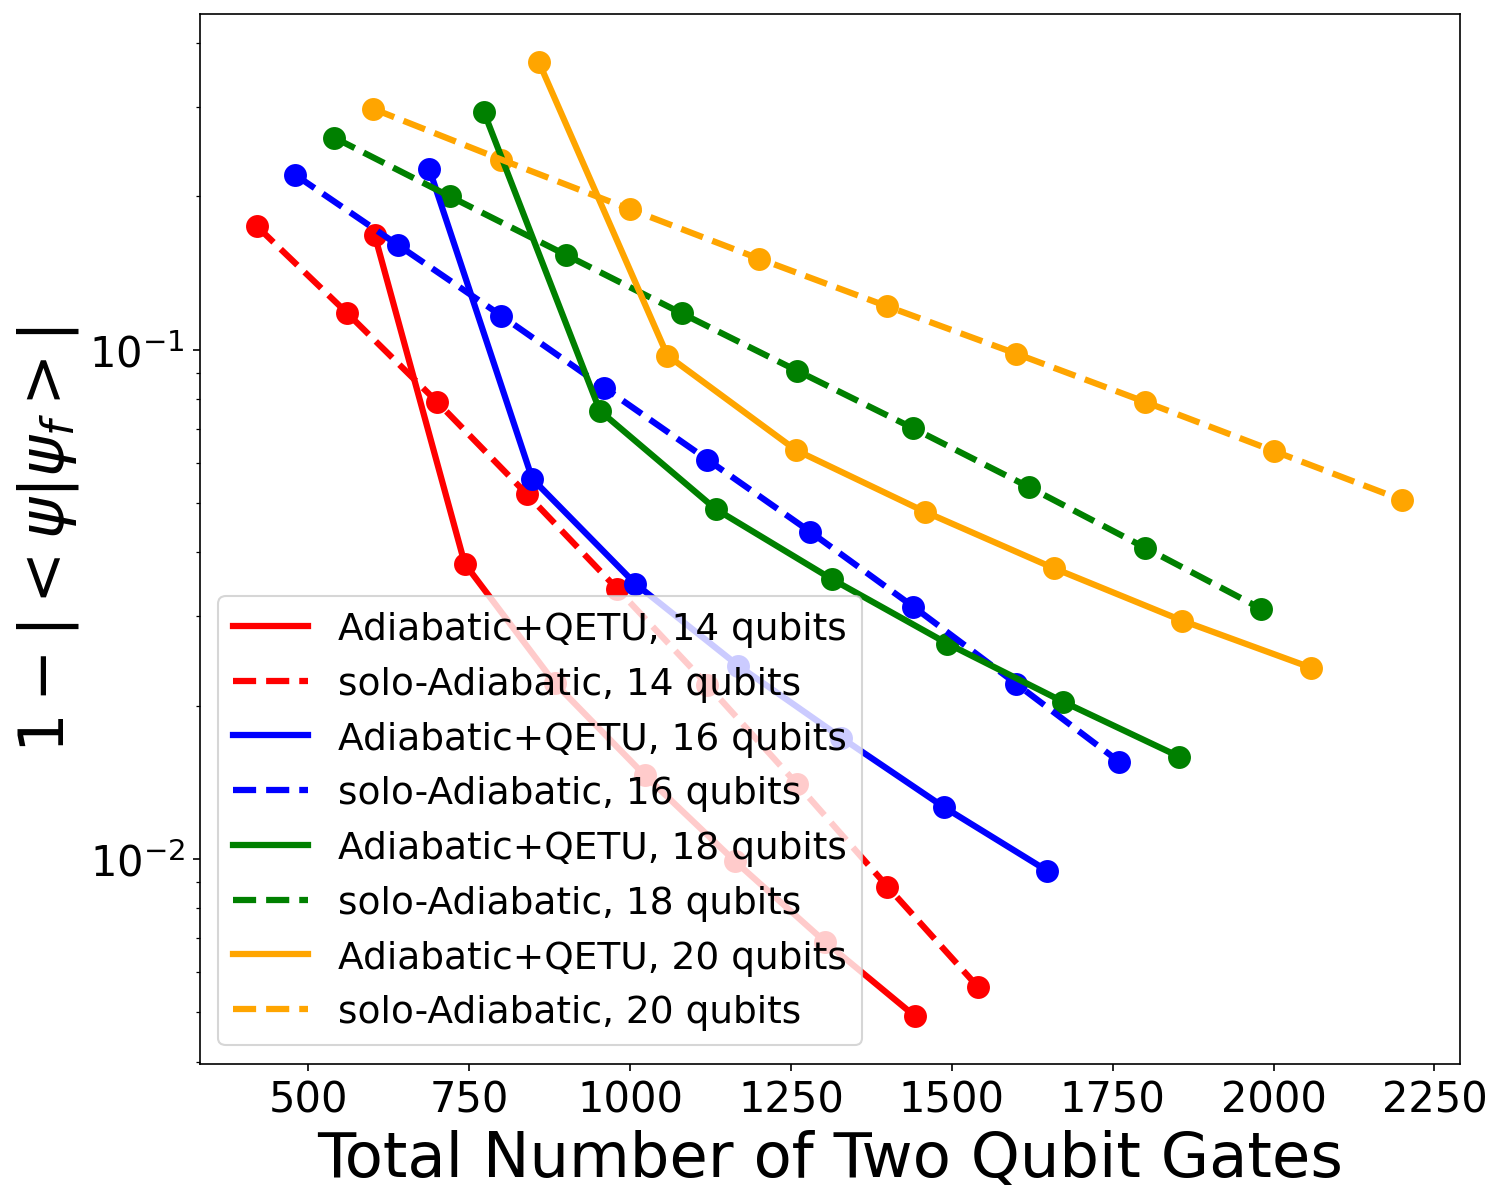

In [133]:
plt.subplots_adjust(left=0.2, bottom=0.1, right=0.9, top=0.8, wspace=0.5, hspace=0.2)
plt.rcParams["figure.figsize"] = (12, 10)
import matplotlib as mpl 
mpl.rcParams['figure.dpi'] = 150

colors = ['red', 'blue', 'green', 'orange']

l = 0
for L in [14, 16, 18, 20]:
    plt.plot(cxs[L], [1-fid for fid in fids[L]], label=f'Adiabatic+QETU, {L} qubits', color=colors[l],linewidth=3.0)  
    plt.scatter(cxs[L], [1-fid for fid in fids[L]], color=colors[l], s=100)
    
    plt.plot(cxs_A[L], [1-fid for fid in fids_A[L]], label=f'solo-Adiabatic, {L} qubits', ls='--', color=colors[l],linewidth=3.0)  
    plt.scatter(cxs_A[L], [1-fid for fid in fids_A[L]], color=colors[l], s=100)    
    l += 1
plt.yscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Total Number of Two Qubit Gates', size=30)
plt.ylabel(r'$1-|<\psi|\psi_f>|$', size=30)
plt.legend(prop={'size': 18}, loc="lower left")

plt.savefig('./figs/Heis_2D_lattices_infid.png')
plt.savefig('./figs/Heis_2D_lattices_infid.pdf')

In [39]:
backend = Aer.get_backend("unitary_simulator")
qc_unit = execute(transpile(qc_Trotter), backend).result().get_unitary(qc_Trotter, L).data
hamil2 = scipy.linalg.logm(qc_unit)/(-1j*0.2)

eigenvalues, eigenvectors = LA.eigsh(hamil2, k=10)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state_TR = eigenvectors_sort[:, 0]

state_fidelity(ground_state_TR, ground_state)

/tmp/ipykernel_10201/1710222164.py:2: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  qc_unit = execute(transpile(qc_Trotter), backend).result().get_unitary(qc_Trotter, L).data


0.9952146352213397

In [134]:
print(fids, cxs, '\n')
print(fids_A, cxs_A)

{16: [0.7738362391159216, 0.9442081629761429, 0.9652740345330388, 0.976028442909359, 0.9826829508265337, 0.9873615387270082, 0.9905124692461306], 18: [0.7075980601714839, 0.9241372256362685, 0.9513617889663661, 0.9645272652508227, 0.9735127377716518, 0.979640730589492, 0.9841063027803045], 20: [0.6327004024230152, 0.9026158558625275, 0.9365387461363807, 0.9519363075238805, 0.9627427809466415, 0.9706232194250728, 0.9762465284891655], 14: [0.8319778470092463, 0.9619883349407645, 0.9778502627606088, 0.9854051395418383, 0.9900991066202595, 0.9931203268415068, 0.9950887615150881]} {16: [688, 848, 1008, 1168, 1328, 1488, 1648], 18: [773, 953, 1133, 1313, 1493, 1673, 1853], 20: [858, 1058, 1258, 1458, 1658, 1858, 2058], 14: [603, 743, 883, 1023, 1163, 1303, 1443]} 

{16: [0.7798219458551655, 0.8397664393064157, 0.8834430858657482, 0.9158333008888793, 0.9391623517831821, 0.9561101222367001, 0.9687027828505245, 0.977913452013921, 0.9844751273376237], 18: [0.7392017789850133, 0.8001428168503164,